In [223]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import joblib
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# transformers
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import BinaryEncoder, TargetEncoder


# estimators
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGB

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# metrics
from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    classification_report,
    mean_absolute_error,
    r2_score,
    mean_squared_error,
    confusion_matrix,
)


data = pd.read_csv("mental_health_dataset.csv")

data.head()


,age,gender,employment_status,work_environment,mental_health_history,seeks_treatment,stress_level,sleep_hours,physical_activity_days,depression_score,anxiety_score,social_support_score,productivity_score,mental_health_risk
0,56,Male,Employed,On-site,Yes,Yes,6,6.2,3,28,17,54,59.7,High
1,46,Female,Student,On-site,No,Yes,10,9.0,4,30,11,85,54.9,High
2,32,Female,Employed,On-site,Yes,No,7,7.7,2,24,7,62,61.3,Medium
3,60,Non-binary,Self-employed,On-site,No,No,4,4.5,4,6,0,95,97.0,Low
4,25,Female,Self-employed,On-site,Yes,Yes,3,5.4,0,24,12,70,69.0,High


In [224]:
X = data.drop("mental_health_risk", axis=1)
y = data["mental_health_risk"]


ss_cols = [
    "age",
    "stress_level",
    "sleep_hours",
    "physical_activity_days",
    "depression_score",
    "anxiety_score",
    "social_support_score",
    "productivity_score",
]

SS = StandardScaler()
SS.fit(X[ss_cols])
X[ss_cols] = SS.transform(X[ss_cols])

most_frequent_gender = X["gender"].mode()[0]
print(f"Most frequent gender: {most_frequent_gender}")

values_to_replace = ["Non-binary", "Prefer not to say"]
replace_with = ["Male", "Female"]
X["gender"] = X["gender"].replace(values_to_replace, replace_with)
X["gender"].value_counts()

X["gender"] = X["gender"].map({"Male": 1, "Female": 0})
X["mental_health_history"] = X["mental_health_history"].map({"Yes": 1, "No": 0})
X["seeks_treatment"] = X["seeks_treatment"].map({"Yes": 1, "No": 0})

y = y.map({"High": 2, "Medium": 1, "Low": 0})


OHE = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False,
)
OHE_cols = ["employment_status", "work_environment"]

OHE_df = OHE.fit_transform(X[OHE_cols])
encoded_df = pd.DataFrame(OHE_df, columns=OHE.get_feature_names_out(OHE_cols))
X = pd.concat([X, encoded_df], axis=1)
X = X.drop(["employment_status", "work_environment"], axis=1)


Most frequent gender: Male


In [225]:
features = ["depression_score", "anxiety_score", "productivity_score"]

X_train, X_test, y_train, y_test = train_test_split(
    X[features], y, random_state=42, test_size=0.2
)


X_train.head()


,depression_score,anxiety_score,productivity_score
9254,0.551711,1.018328,0.091589
1561,-1.005507,0.069310,0.710344
1670,0.218022,1.176498,0.034692
6087,1.219091,-1.196048,-1.188593
6669,0.329252,1.492837,-0.356475


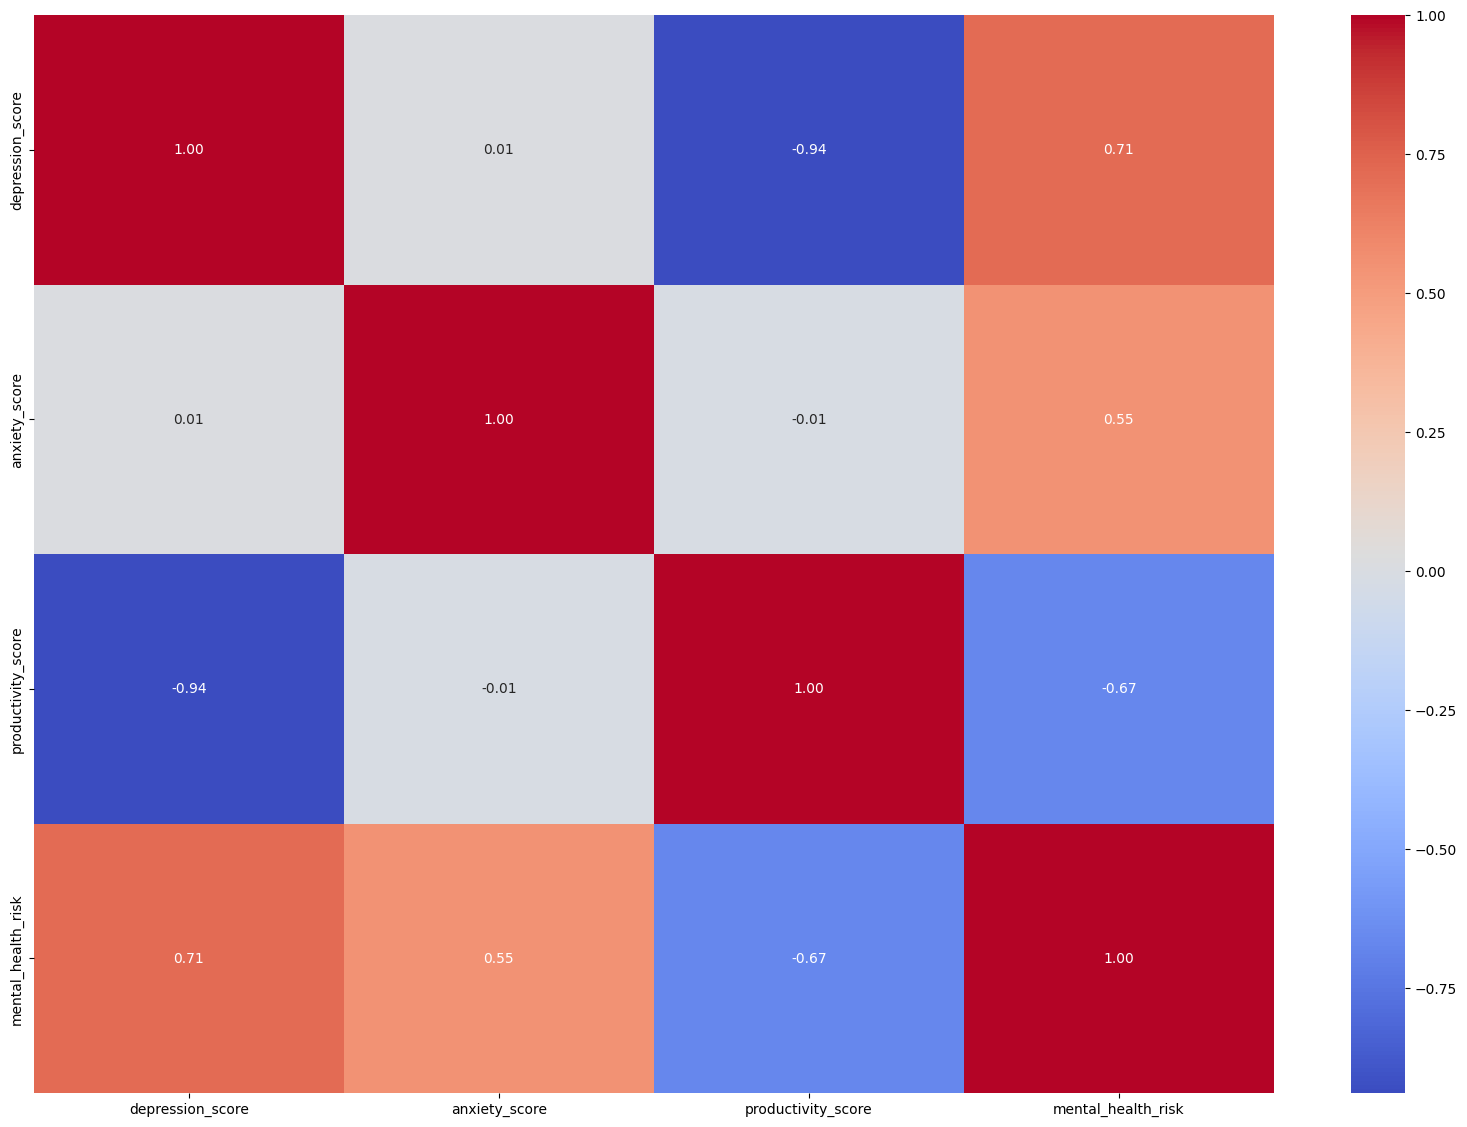

In [226]:

temp = pd.concat([X_train, X_test], axis=0)
temp = pd.concat([temp, y], axis=1)

corr = temp.corr()
plt.figure(figsize=[20, 14])
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()


mean_absolute_error = 0.0009500000000000004
mean_squared_error = 0.00013500000000000006



[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  10 out of  10 | elapsed:    0.0s finished


((array([-3.39232293, -3.14126578, -3.00201262, ...,  3.00201262,
          3.14126578,  3.39232293], shape=(2000,)),
  array([-0.2, -0.1, -0.1, ...,  0.1,  0.1,  0.3], shape=(2000,))),
 (np.float64(0.0028396135597759313),
  np.float64(0.00035000000000000076),
  np.float64(0.2441370417250411)))

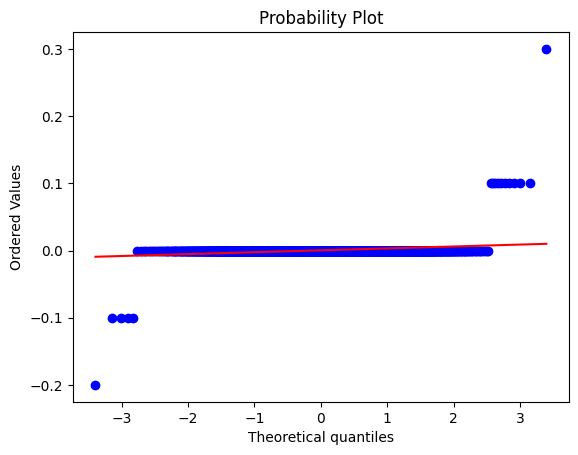

In [227]:
RFR = RandomForestRegressor(n_estimators=10, n_jobs=3, random_state=42, verbose=1)
RFR.fit(X_train, y_train)


test_pred = RFR.predict(X_test)

residuals = y_test - test_pred

mae = mean_absolute_error(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)

print(f"mean_absolute_error = {mae}")
print(f"mean_squared_error = {mse}\n")

stats.probplot(residuals, dist="norm", plot=plt)


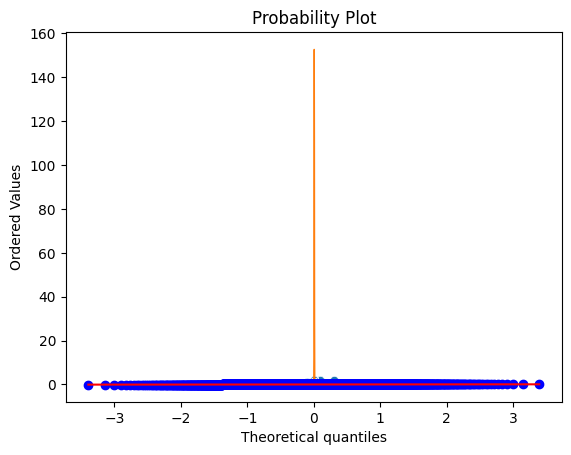

0.011154298670589924 0.0007191327749751508


In [228]:
model = XGB.XGBRegressor(
    objective="reg:squarederror", n_estimators=100, random_state=42
)
model.fit(X_train, y_train)

XGB_pred = model.predict(X_test)
# test_pred = np.round(model.predict(X_test)).astype(int)

XGB_residuals = y_test - XGB_pred
sns.scatterplot(x=residuals,y= XGB_pred)
# plt.hist(residuals, bins=20, edgecolor="black")
sns.kdeplot(residuals, fill=True)
stats.probplot(XGB_residuals, dist="norm", plot=plt)
plt.show()

mae = mean_absolute_error(y_test, XGB_pred)
mse = mean_squared_error(y_test, XGB_pred)
print(mae, mse)


0.0145 0.0145


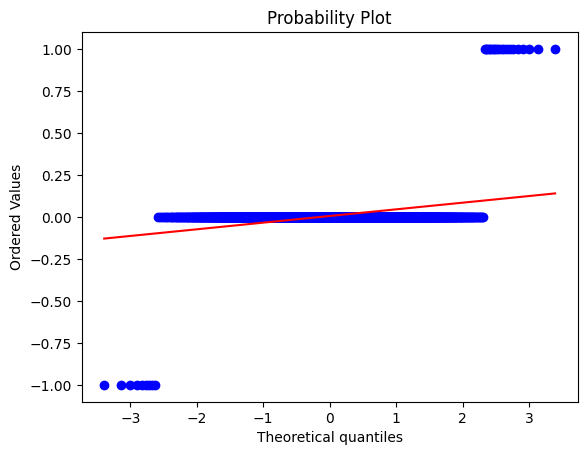

In [229]:
KNN = KNeighborsClassifier(n_neighbors=3)
KNN.fit(X_train, y_train)

KNN_pred = KNN.predict(X_test)
mae = mean_absolute_error(y_test, KNN_pred)
mse = mean_squared_error(y_test, KNN_pred)

residuals = y_test - KNN_pred
# sns.scatterplot(x=residuals,y= test_pred)
# plt.hist(residuals, bins=20, edgecolor="black")
# sns.kdeplot(residuals, fill=True)
stats.probplot(residuals, dist="norm", plot=plt)


print(mae, mse)
